### Setup: Import Dependencies
Run the cell below to import the relevant dependencies.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import functools

### Part 1: CMA-ES
Implement CMA-ES below.

In [ ]:
def cmaes(fn, dim, num_iter=10):
  """Optimizes a given function using CMA-ES.

  Args:
    fn: A function that takes as input a vector and outputs a scalar value.
    dim: (int) The dimension of the vector that fn expects as input.
    num_iter: (int) Number of iterations to run CMA-ES.

  Returns:
    mu_vec: An array of size [num_iter, dim] storing the value of mu at each
      iteration.
    best_sample_vec: A list of length [num_iter] storing the function value
      for the best sample from each iteration of CMA-ES.
    mean_sample_vec: A list of length [num_iter] storing the average function
      value across samples from each iteration of CMA-ES.
  """
  # Hyperparameters
  sigma = 10
  population_size = 100
  p_keep = 0.10  # Fraction of population to keep
  noise = 0.25  # Noise added to covariance to prevent it from going to 0.

  # Initialize the mean and covariance
  mu = np.zeros(dim)
  cov = sigma**2 * np.eye(dim)

  mu_vec = []
  best_sample_vec = []
  mean_sample_vec = []
  for t in range(num_iter):
    population_xs = np.random.multivariate_normal(mu, cov, population_size)
    fitnesses = [fn(x) for x in population_xs]
    population = list(zip(population_xs, fitnesses))
    population.sort(key=(lambda x: x[1]), reverse=True)
    # print(population)
    best_sample_vec.append(population[0][1])

    elite = population[:(int)(p_keep * population_size)]
    mu = np.mean([x[0] for x in elite], axis=0)
    cov = np.cov([x[0] for x in elite], rowvar=False) + noise * np.eye(dim)
    # note: noise is so important! try running without noise: it fails terribly
    mu_vec.append(mu)
    mean_sample_vec.append(np.mean(fitnesses))
    # print(mu)

  return mu_vec, best_sample_vec, mean_sample_vec

In the cell below, we've defined a simply function:
$$f(x) = -\|x - x^*\|_2^2 \quad \text{where} \quad x^* = [65, 49].$$
This function is optimized when $x = x^*$. Run your implementation of CMA-ES on this function, confirming that you get the correct solution.

In [ ]:
def test_fn(x):
  goal = np.array([65, 49])
  return -np.sum((x - goal)**2)

mu_vec, best_sample_vec, mean_sample_vec = cmaes(test_fn, dim=2, num_iter=100)

Run the following cell to visualize CMA-ES.

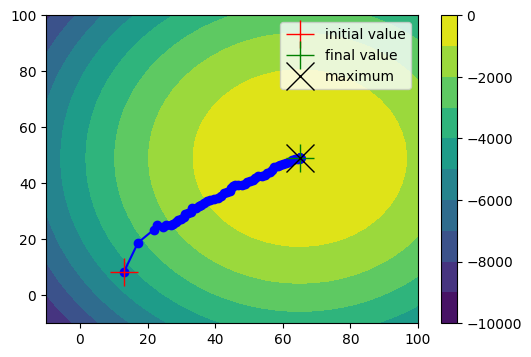

In [ ]:
x = np.stack(np.meshgrid(np.linspace(-10, 100, 30), np.linspace(-10, 100, 30)), axis=-1)
fn_value = [test_fn(xx) for xx in x.reshape((-1, 2))]
fn_value = np.array(fn_value).reshape((30, 30))
plt.figure(figsize=(6, 4))
plt.contourf(x[:, :, 0], x[:, :, 1], fn_value, levels=10)
plt.colorbar()
mu_vec = np.array(mu_vec)
plt.plot(mu_vec[:, 0], mu_vec[:, 1], 'b-o')
plt.plot([mu_vec[0, 0]], [mu_vec[0, 1]], 'r+', ms=20, label='initial value')
plt.plot([mu_vec[-1, 0]], [mu_vec[-1, 1]], 'g+', ms=20, label='final value')
plt.plot([65], [49], 'kx', ms=20, label='maximum')
plt.legend()
plt.show()

Next, you will apply CMA-ES to a more complicating: maximizing the expected reward of a RL agent. The policy takes action LEFT with probability:
$$\pi(a = \text{LEFT} \mid s) = s \cdot w + b,$$
where $w \in \mathbb{R}^4$ and $b \in \mathbb{R}$ are parameters that you will optimize with CMA-ES. In the cell below, define a function that takes as input a single vector $x = (w, b)$ and the environment and returns the total (undiscounted) reward from one episode.

In [ ]:
def _sigmoid(x):
  return 1 / (1 + np.exp(-x))

def _get_action(s, params):
  w = params[:4]
  b = params[4]
  p_left = _sigmoid(w @ s + b)
  a = np.random.choice(2, p=[p_left, 1 - p_left])
  return a

def rl_fn(params, env):
  assert len(params) == 5
  total_rewards = 0
  s = env.reset()
  done = False
  while not done:
    a = _get_action(s, params)
    s, r, done, _ = env.step(a)
    total_rewards += r
  return total_rewards

In [ ]:
policies = [np.array([-1,-1,-1,-1,-1]), np.array([1,0,1,0,1]), np.array([0,1,2,3,4])]
for p in policies:
    rewards = 0
    for i in range(1000):
        rewards += rl_fn(p, gym.make('CartPole-v0'))
    print(f"Policy {p} had rewards {rewards/1000}")

Policy [-1 -1 -1 -1 -1] had rewards 15.558
Policy [1 0 1 0 1] had rewards 14.617
Policy [0 1 2 3 4] had rewards 9.482


The cell below applies your CMA-ES implementation to the RL objective you've defined in the cell above.

In [ ]:
env = gym.make('CartPole-v0')
fn_with_env = functools.partial(rl_fn, env=env)
mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=10)

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated,

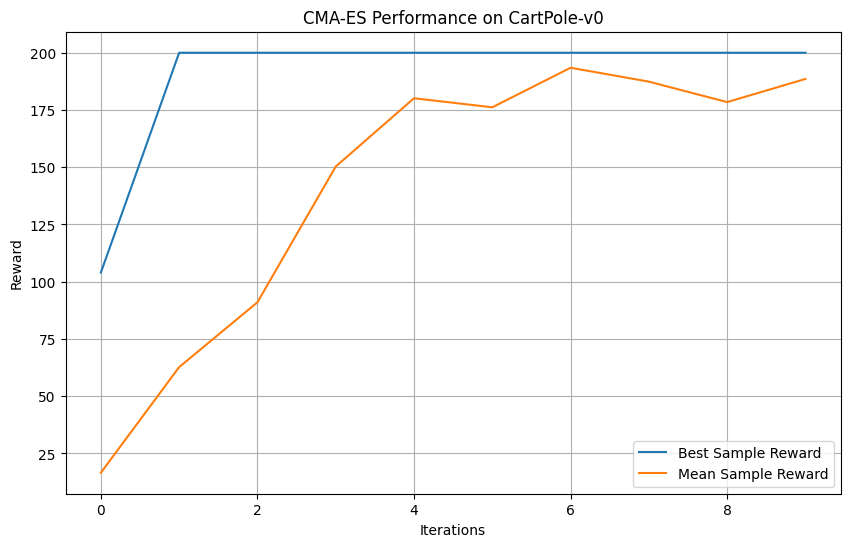

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_sample_vec, label='Best Sample Reward')
plt.plot(mean_sample_vec, label='Mean Sample Reward')
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('CMA-ES Performance on CartPole-v0')
plt.legend()
plt.grid(True)
plt.show()
